In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from energySystem import System, NaturalGasFurnace, HeatPump, Battery, ThermalStorage, PVsystem
import default_values as DEFAULT

In [26]:
sns.set_context(context="notebook")
plt.rcParams["figure.dpi"] = 300

## Import data

In [27]:
def get_demand_mask_and_price(df, colName, dt):
    col = df[colName].to_numpy() / dt
    mask = col > 0
    price = col[mask][0]
    return mask, price

In [28]:
##### loads
df = pd.read_csv("site1_load.csv")
dt = 1/4 # in hours
powerLoad, heatLoad = df['Power Load [kWh]'].to_numpy(), df['Heat Load [kWh]'].to_numpy()

##### prices
df = pd.read_csv("power_price_B20.csv")
energyPricePower = df["energyPrice"].to_numpy() # $/kWh
# from per kW to per kWh in 15 minutes
powerDemandFee = [get_demand_mask_and_price(df, colName, dt) for colName in ["peakDemandSummerPrice",
                                                                          "partialPeakDemandSummerPrice",
                                                                          "demandSummerPrice",
                                                                          "peakDemandWinterPrice",
                                                                          "demandWinterPrice"]]
df = pd.read_csv("gas_price.csv")
energyPriceGas = df["energyPrice"].to_numpy() # $/kWh

##### emissions
df = pd.read_csv("power_grid_emissions.csv")
df.ffill(inplace=True)
emissionsPower = df["MOER version 2.0"].to_numpy() # kCO2eq/KWhe
df = pd.read_csv("gas_emissions.csv")
emissionsGas = df["gasEmissions"].to_numpy() # kCO2eq/kWhgas

##### pv load
df = pd.read_csv("pv_utilityscale_load.csv")
pvuLoad = df["0"].to_numpy()

##### time index
timeIndex = pd.date_range(start='1/1/2023', periods=len(powerLoad), freq='15min')

# clear memory
del df

In [29]:
# number of timesteps
n_timesteps = len(powerLoad)

## Natural Gas Only

In [30]:
system1 = System(
    "baseline",
    timeIndex=timeIndex,
    powerLoad=powerLoad,
    heatLoad=heatLoad,
    powerPrice=energyPricePower,
    powerDemandFee=powerDemandFee,
    gasPrice=energyPriceGas,
    powerMarginalEmissions=emissionsPower,
    gasMarginalEmissions=emissionsGas
)
ngf1 = NaturalGasFurnace(
    n_timesteps=n_timesteps,
    dt=1/4,
    eff=DEFAULT.FURNACE_EFF,
    capacityPrice=DEFAULT.FURNACE_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.FURNACE_LIFETIME)
system1.addComponent(ngf1)
system1.solve(objective="cost", solver="MOSEK")
system1.describe()


System: baseline
1 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 8734.0 kW
Status: optimal

Annual power consumption: 10000.0 MWh
Annual gas consumption: 34521.0 MWh
Annual cost: 3.721 M$
Annual emissions: 11.65 MtonCO2
LCOE (Electricity): 0.211 $/kWh
LCOH (Heat): 0.055 $/kWh
Carbon Intensity of Electricity: 0.367 kgCO2/kWhe
Carbon Intensity of Heat: 0.272 kgCO2/kWhth



A sanity check: max capa of the gas furnace should be max(heatLoad)/dt

In [31]:
print(f"The difference is {heatLoad.max()/dt - ngf1._variables[1].value} kW.")

The difference is 0.0 kW.


In [32]:
baselineEmissions = system1.totalEmissions.value

## Natural Gas and Heat Pump

In [33]:
hp1 = HeatPump(
    n_timesteps=n_timesteps,
    dt=1/4,
    COP=DEFAULT.HP_COP,
    capacityPrice=DEFAULT.HP_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.HP_LIFETIME
)
system1.addComponent(hp1)
system1.solve(objective="cost", emissionsCap=0.8*baselineEmissions, solver="MOSEK")
system1.describe()

System: baseline
2 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 8423.0 kW
Component: HeatPump
    capacityPrice: 1000
    COP: 3
    Optimal capacity: 2384.0 kW
Status: optimal

Annual power consumption: 14964.0 MWh
Annual gas consumption: 17001.0 MWh
Annual cost: 3.853 M$
Annual emissions: 9.32 MtonCO2
LCOE (Electricity): 0.204 $/kWh
LCOH (Heat): 0.062 $/kWh
Carbon Intensity of Electricity: 0.36 kgCO2/kWhe
Carbon Intensity of Heat: 0.195 kgCO2/kWhth



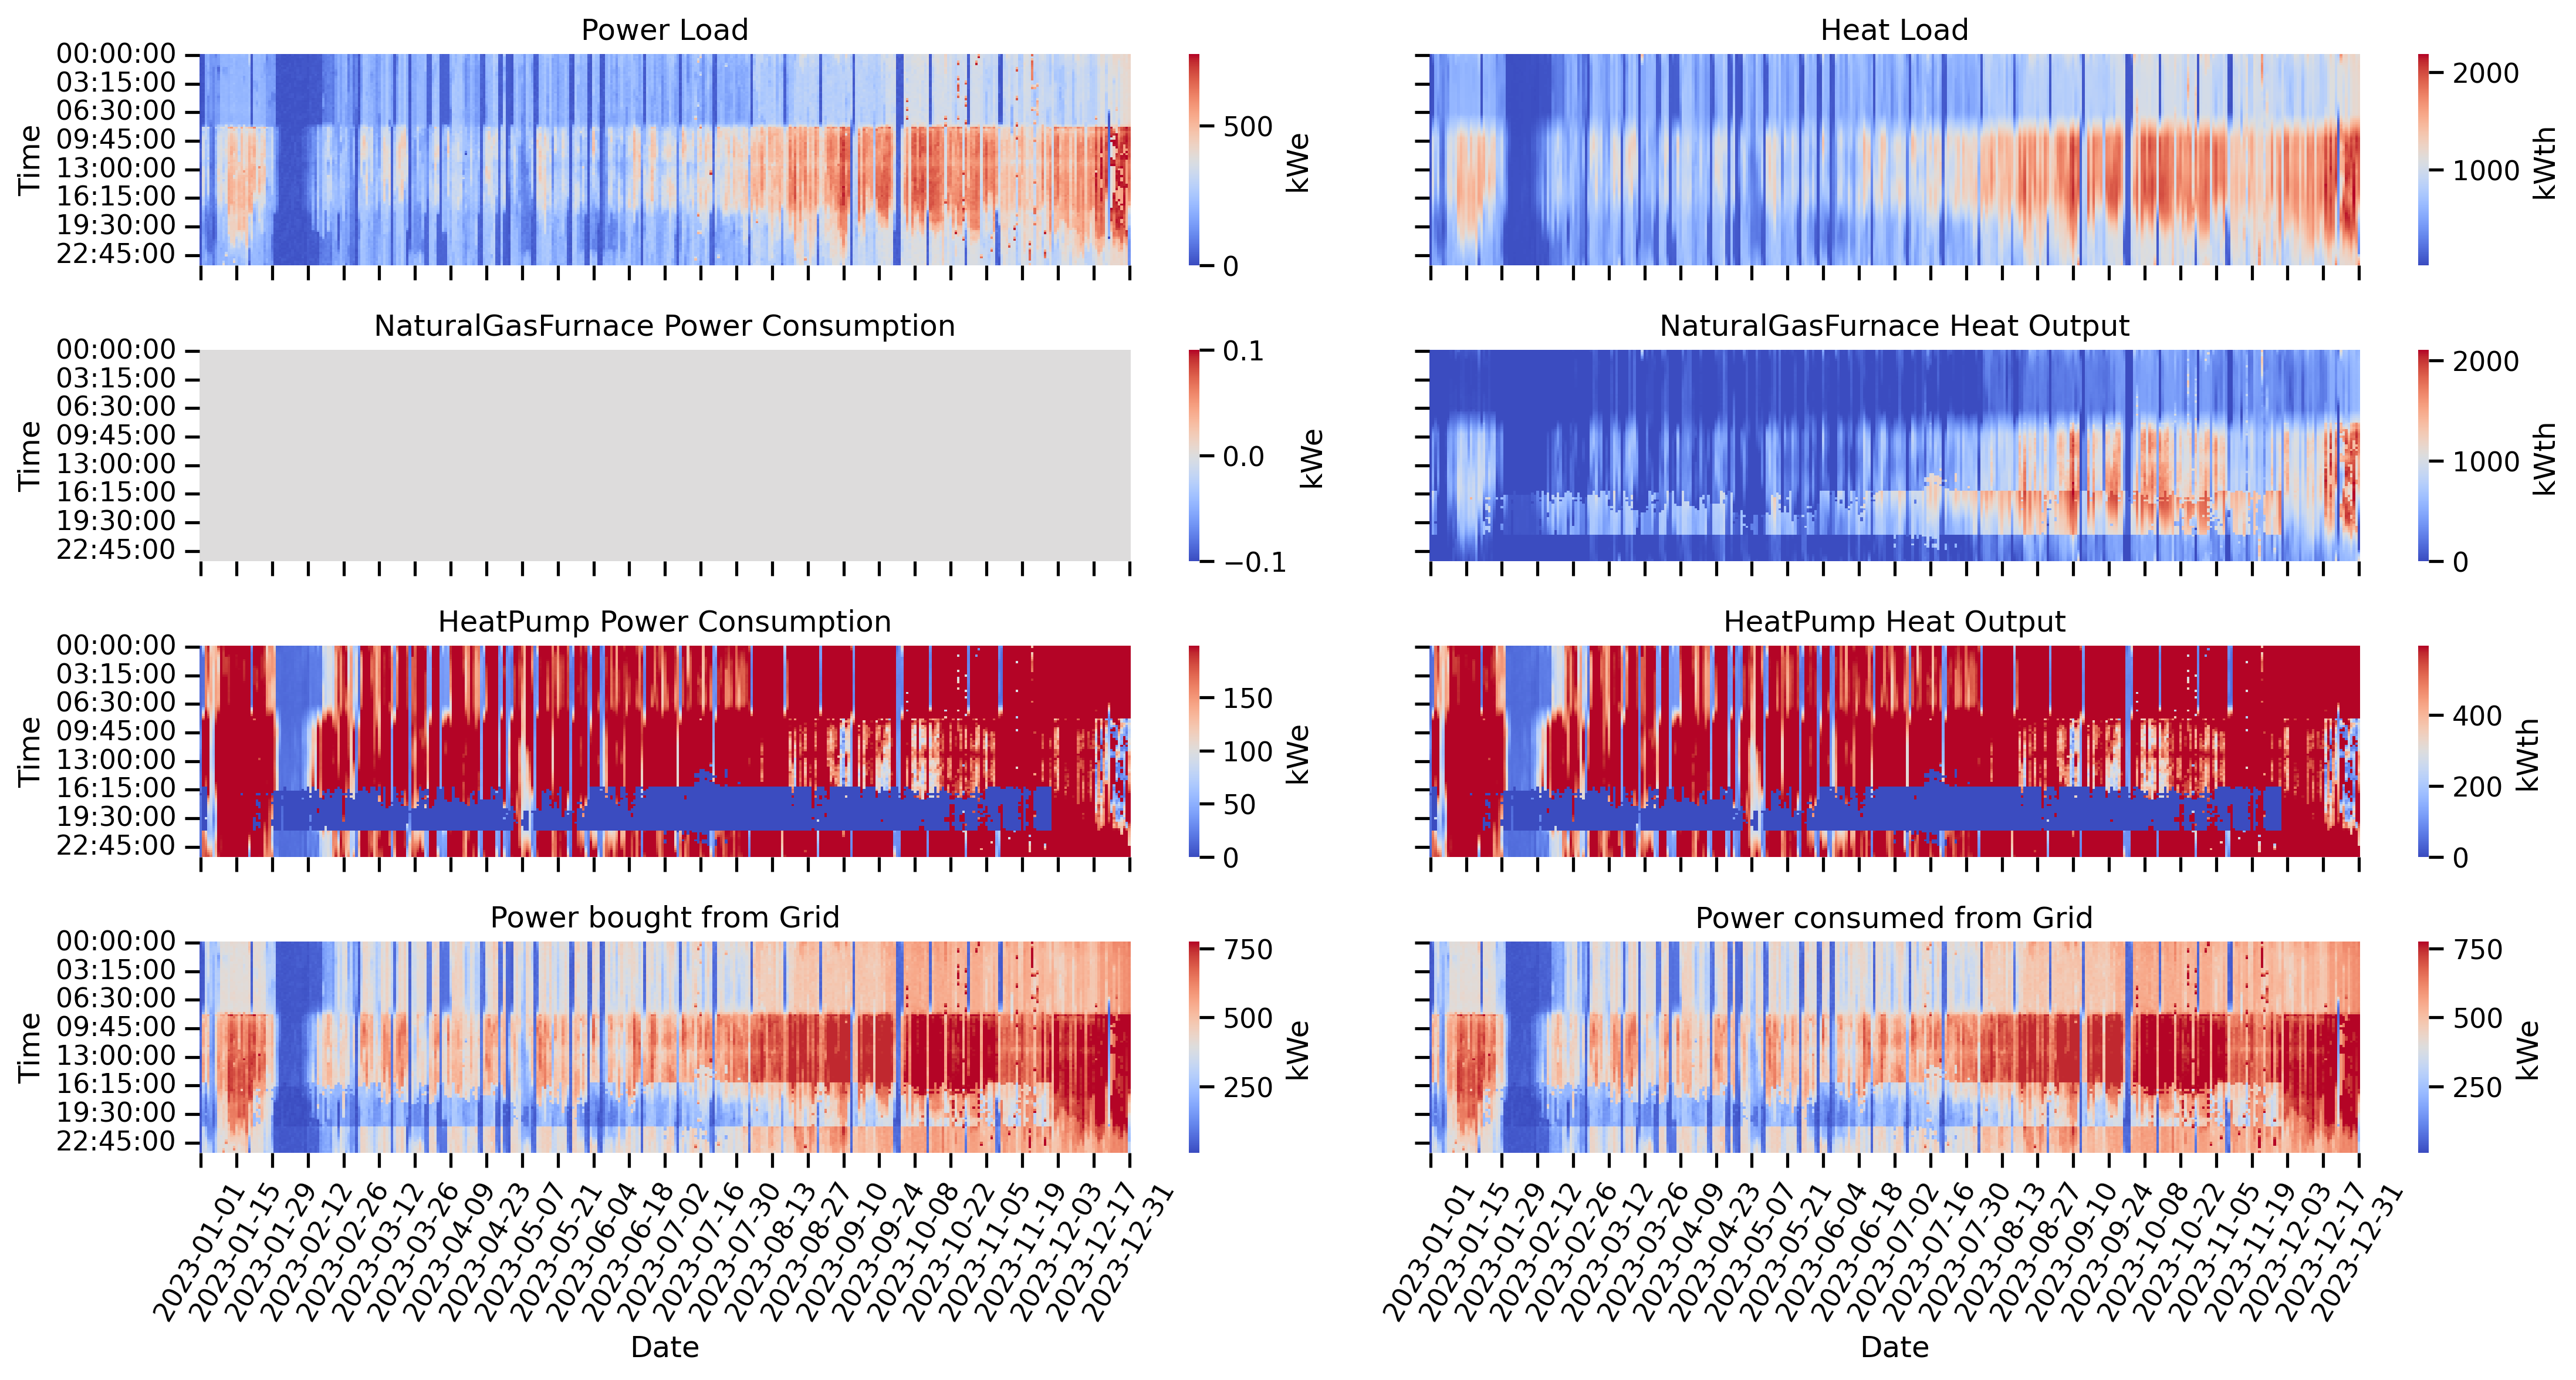

In [34]:
system1.plotHeatmaps();

## Natural Gas and Heat Pump and Battery

In [35]:
lion1 = Battery(
    n_timesteps=n_timesteps,
    dt=1/4,
    maxChargeRate=DEFAULT.LION_MAX_CHARGE_RATE,
    capacityPrice=DEFAULT.LION_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.LION_LIFETIME,
    name="Lithium Ion Battery"
)
system1.addComponent(lion1)
system1.solve(objective="cost", emissionsCap=0.7*baselineEmissions, solver="MOSEK")
system1.describe()

System: baseline
3 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 8043.0 kW
Component: HeatPump
    capacityPrice: 1000
    COP: 3
    Optimal capacity: 2830.0 kW
Component: Lithium Ion Battery
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    maxDischargeRate: 0.25
    maxChargeRate: 0.25
    capacityPrice: 396.75
    Optimal energy capacity: 7200.0 kWh
    Optimal power capacity: 1800.0 kW
Status: optimal

Annual power consumption: 16372.0 MWh
Annual gas consumption: 12030.0 MWh
Annual cost: 3.913 M$
Annual emissions: 8.15 MtonCO2
LCOE (Electricity): 0.204 $/kWh
LCOH (Heat): 0.064 $/kWh
Carbon Intensity of Electricity: 0.328 kgCO2/kWhe
Carbon Intensity of Heat: 0.166 kgCO2/kWhth



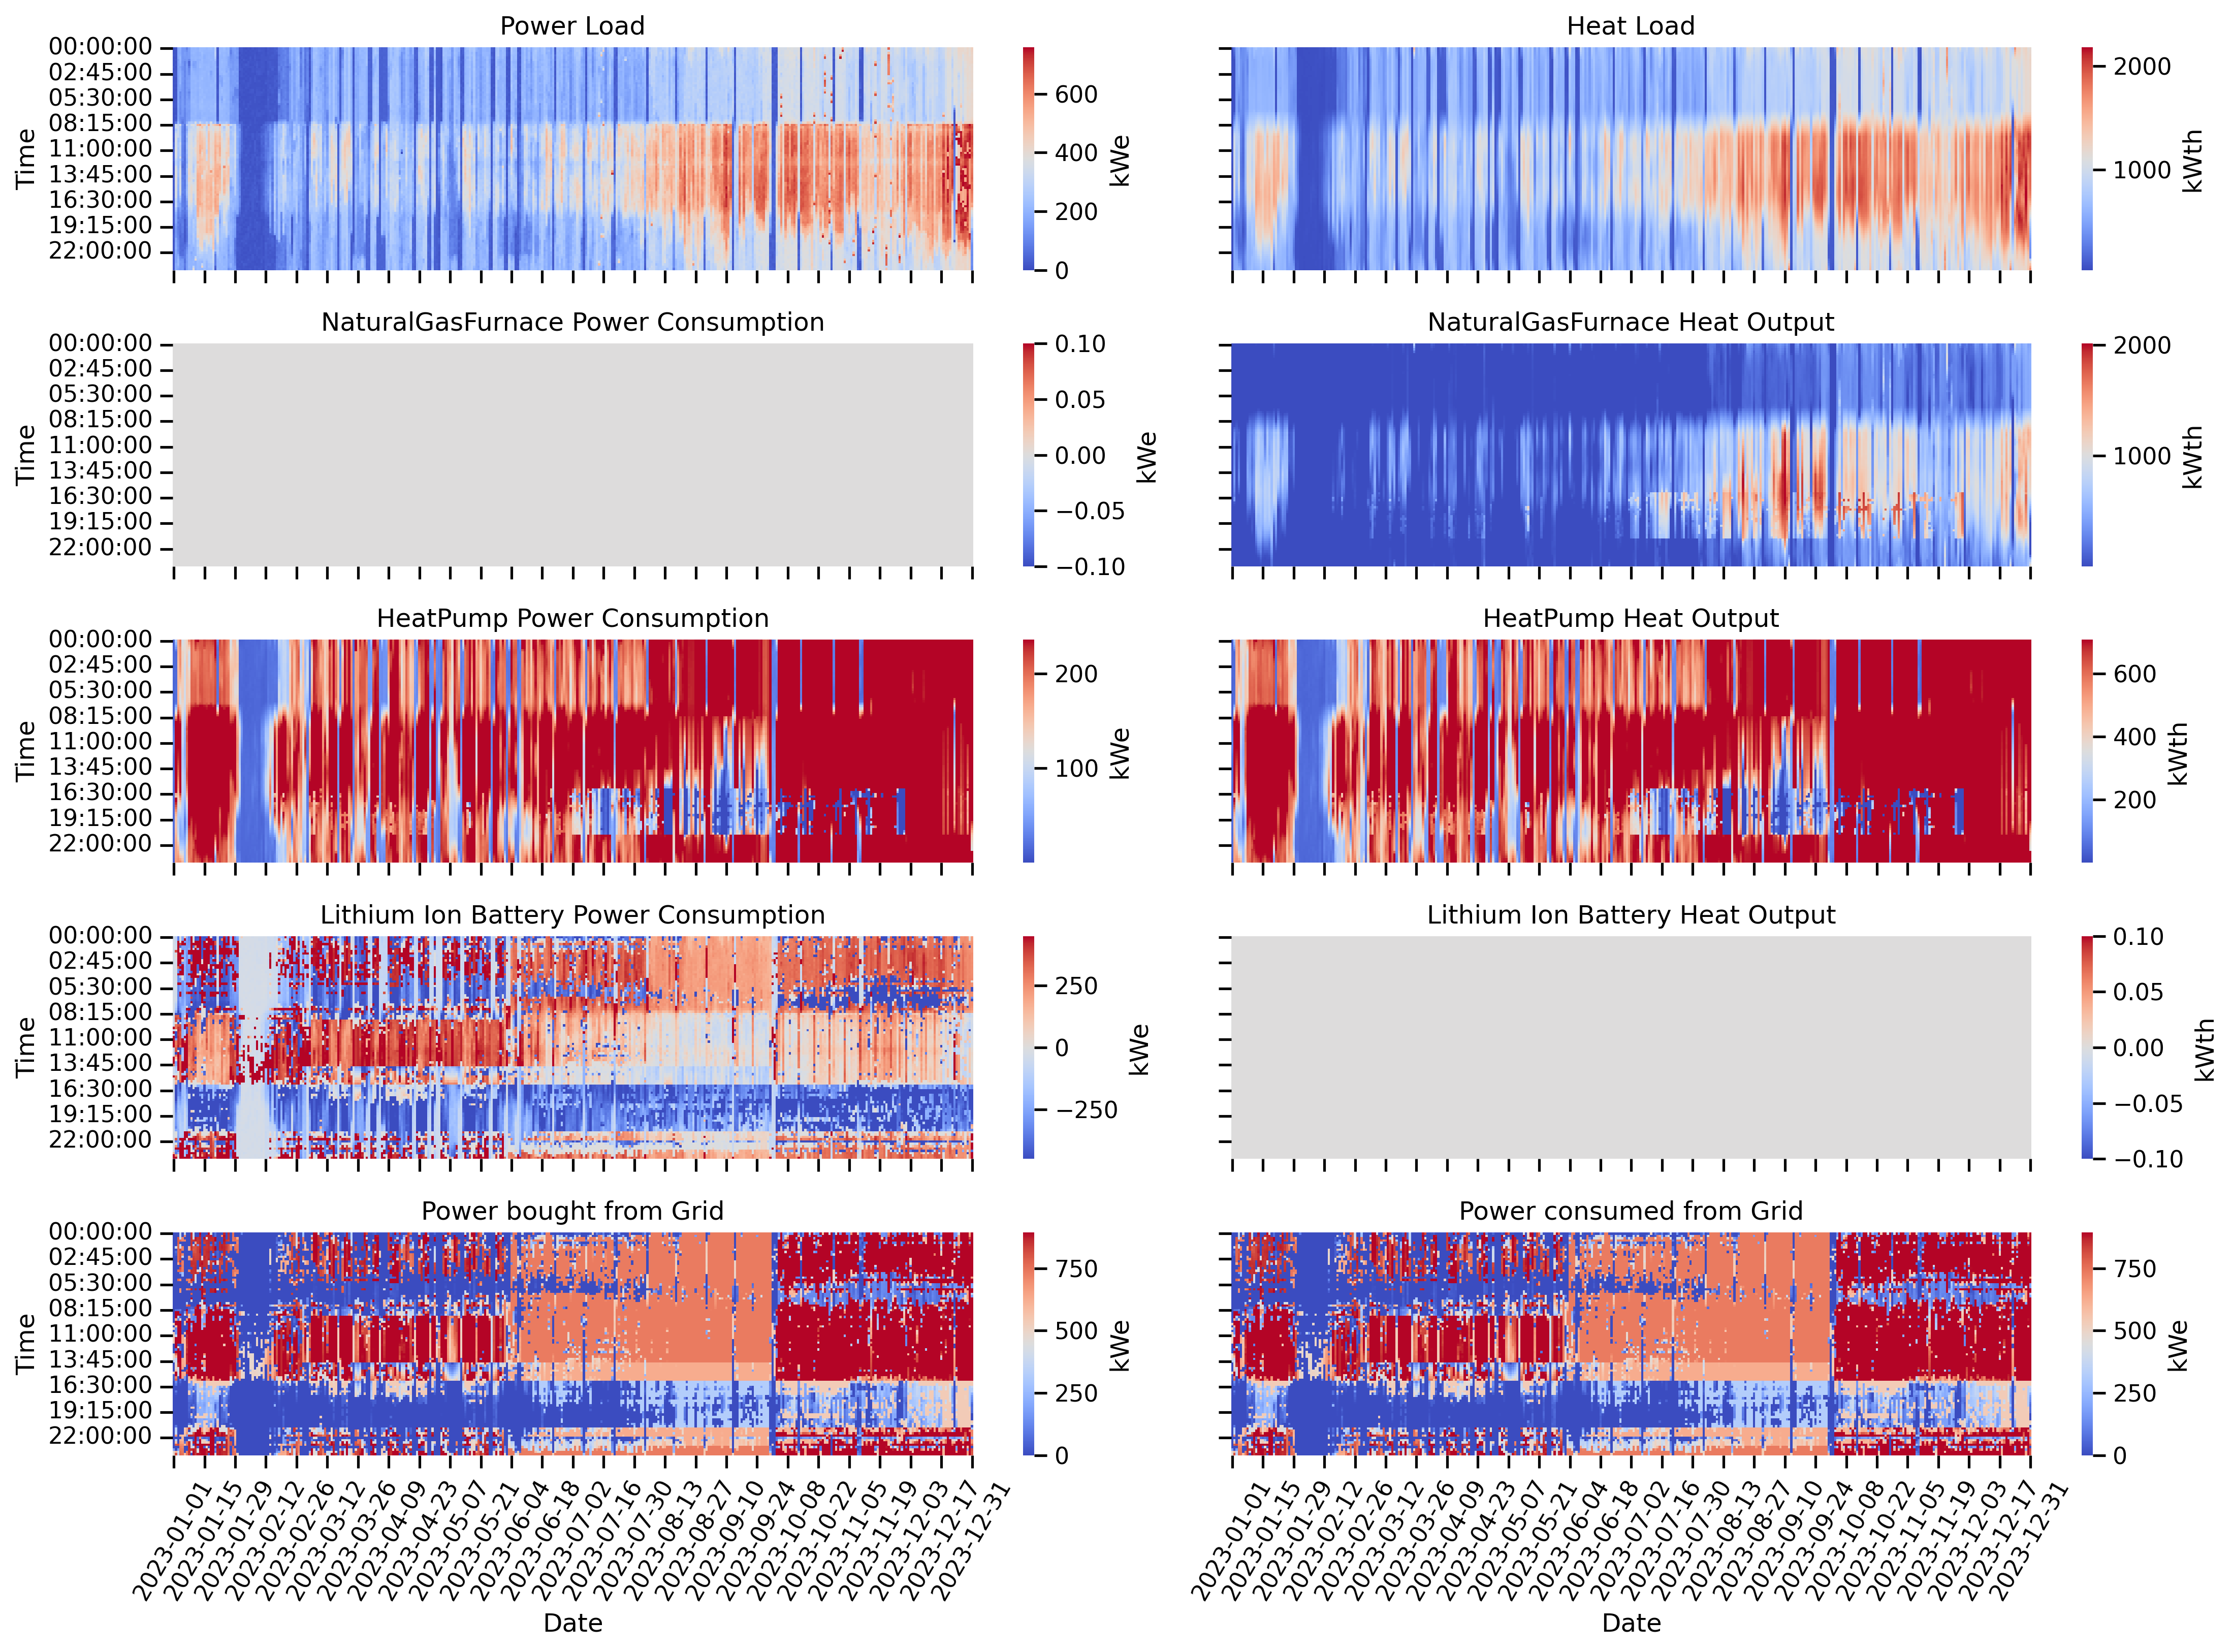

In [36]:
system1.plotHeatmaps();

## Natural Gas and Heat Pump and Battery and Thermal Energy Storage

In [37]:
tes1 = ThermalStorage(
    n_timesteps=n_timesteps,
    dt=1/4,
    maxChargeRate=DEFAULT.TES_MAX_CHARGE_RATE,
    lossRate=DEFAULT.TES_LOSS_RATE,
    capacityPrice=DEFAULT.TES_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.TES_LIFETIME
)
system1.addComponent(tes1)
system1.solve(objective="cost", emissionsCap=0.7*baselineEmissions, solver="MOSEK")
system1.describe()

System: baseline
4 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 2857.0 kW
Component: HeatPump
    capacityPrice: 1000
    COP: 3
    Optimal capacity: 2974.0 kW
Component: Lithium Ion Battery
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    maxDischargeRate: 0.25
    maxChargeRate: 0.25
    capacityPrice: 396.75
    Optimal energy capacity: 4894.0 kWh
    Optimal power capacity: 1223.0 kW
Component: ThermalStorage
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    maxDischargeRate: 0.01
    maxChargeRate: 0.01
    capacityPrice: 2.0
    lossRate: 0
    Optimal energy capacity: 139170.0 kWh
    Optimal power capacity: 1392.0 kW
Status: optimal

Annual power consumption: 16585.0 MWh
Annual gas consumption: 11280.0 MWh
Annual cost: 3.788 M$
Annual emissions: 8.15 MtonCO2
LCOE (Electricity): 0.196 $/kWh
LCOH (Heat): 0.062 $/kWh
Carbon Intensity of Electricity: 0.334 kgCO2/kWhe
Carbon Intensity o

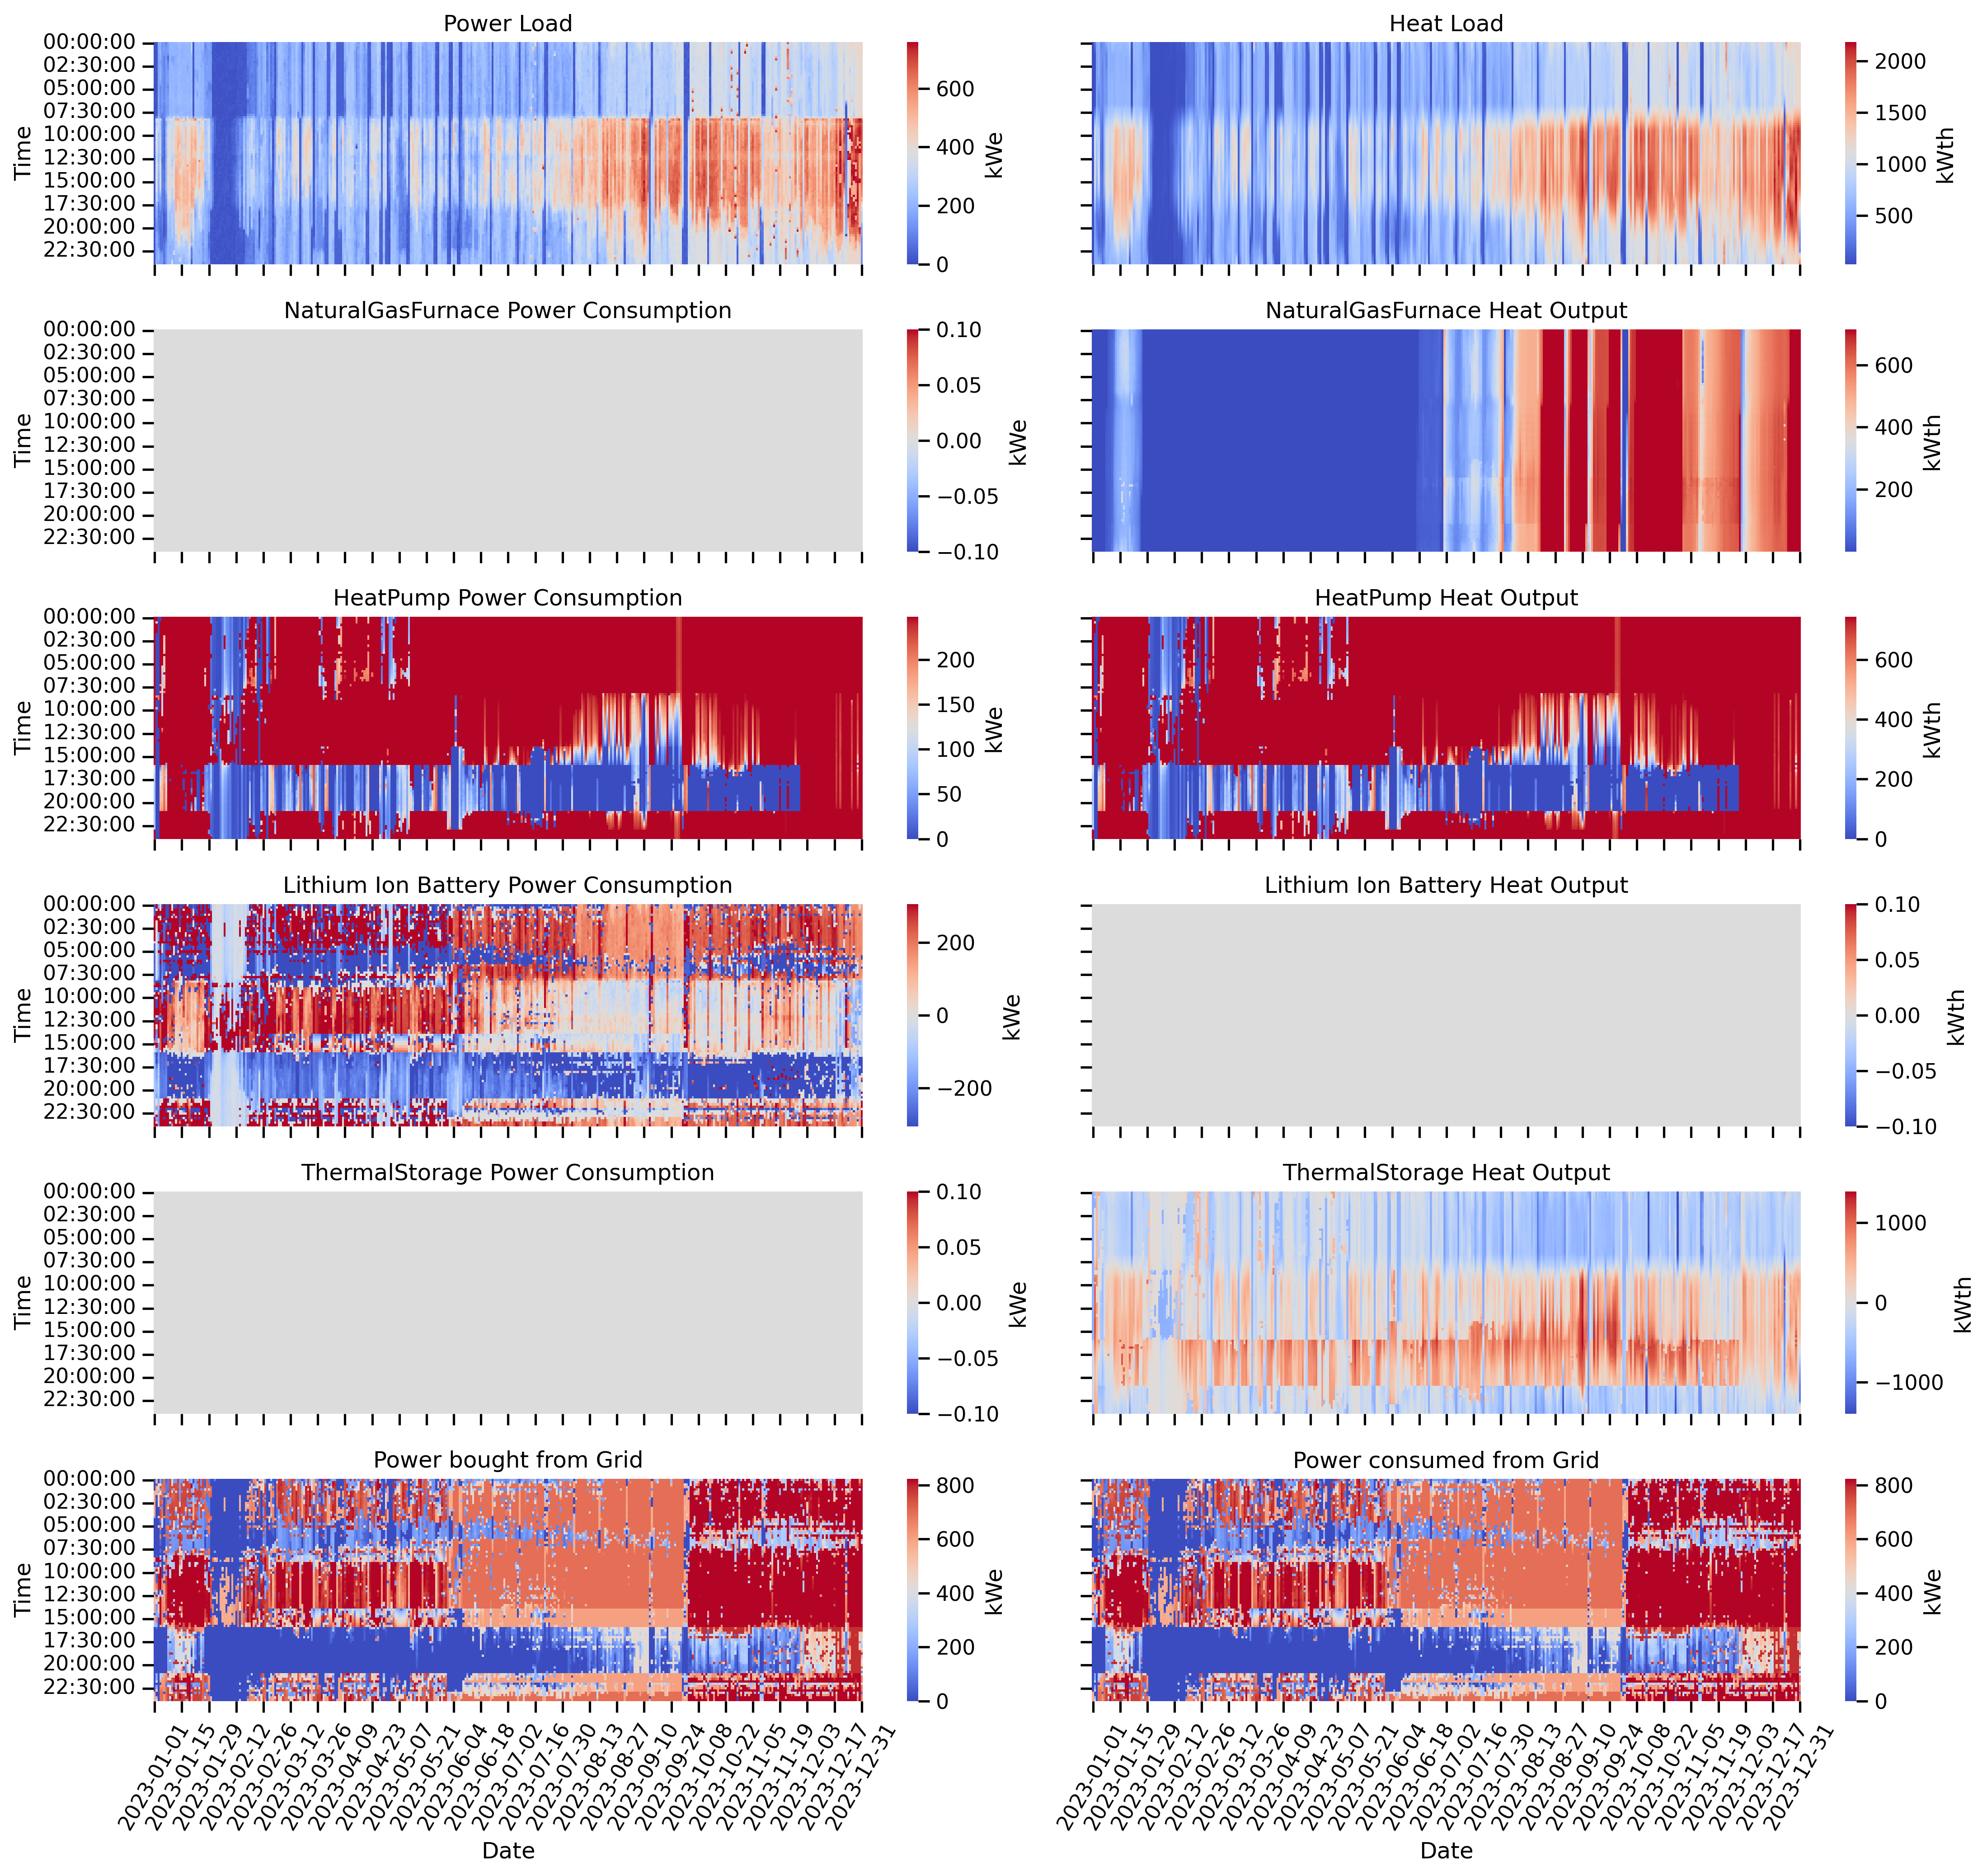

In [38]:
system1.plotHeatmaps();

## Natural Gas and Heat Pump and Battery and Thermal Energy Storage and offsite PV

In [39]:
pvu1 = PVsystem(
    n_timesteps=n_timesteps,
    dt=1/4,
    pvLoadProfile=pvuLoad,
    ppaPrice=DEFAULT.PV_PPA_PRICE,
    averageEmissions=DEFAULT.PV_AVG_EMISSIONS,
    onsite=False
)
system1.addComponent(pvu1)
system1.solve(objective="cost", emissionsCap=0.7*baselineEmissions, solver="MOSEK")
system1.describe()

System: baseline
5 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 2095.0 kW
Component: HeatPump
    capacityPrice: 1000
    COP: 3
    Optimal capacity: 3683.0 kW
Component: Lithium Ion Battery
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    maxDischargeRate: 0.25
    maxChargeRate: 0.25
    capacityPrice: 396.75
    Optimal energy capacity: 4272.0 kWh
    Optimal power capacity: 1068.0 kW
Component: ThermalStorage
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    maxDischargeRate: 0.01
    maxChargeRate: 0.01
    capacityPrice: 2.0
    lossRate: 0
    Optimal energy capacity: 158200.0 kWh
    Optimal power capacity: 1582.0 kW
Component: PVsystem
    ppaPrice: 0.04
    pvLoadProfile: [0. 0. 0. ... 0. 0. 0.]
    onsite: False
    Optimal power capacity: 5.06 MW
    Annual emissions: 0.31 MtonCO2
Status: optimal

Annual power consumption: 7115.0 MWh
Annual gas consumption: 8580.0 MWh
Annual co

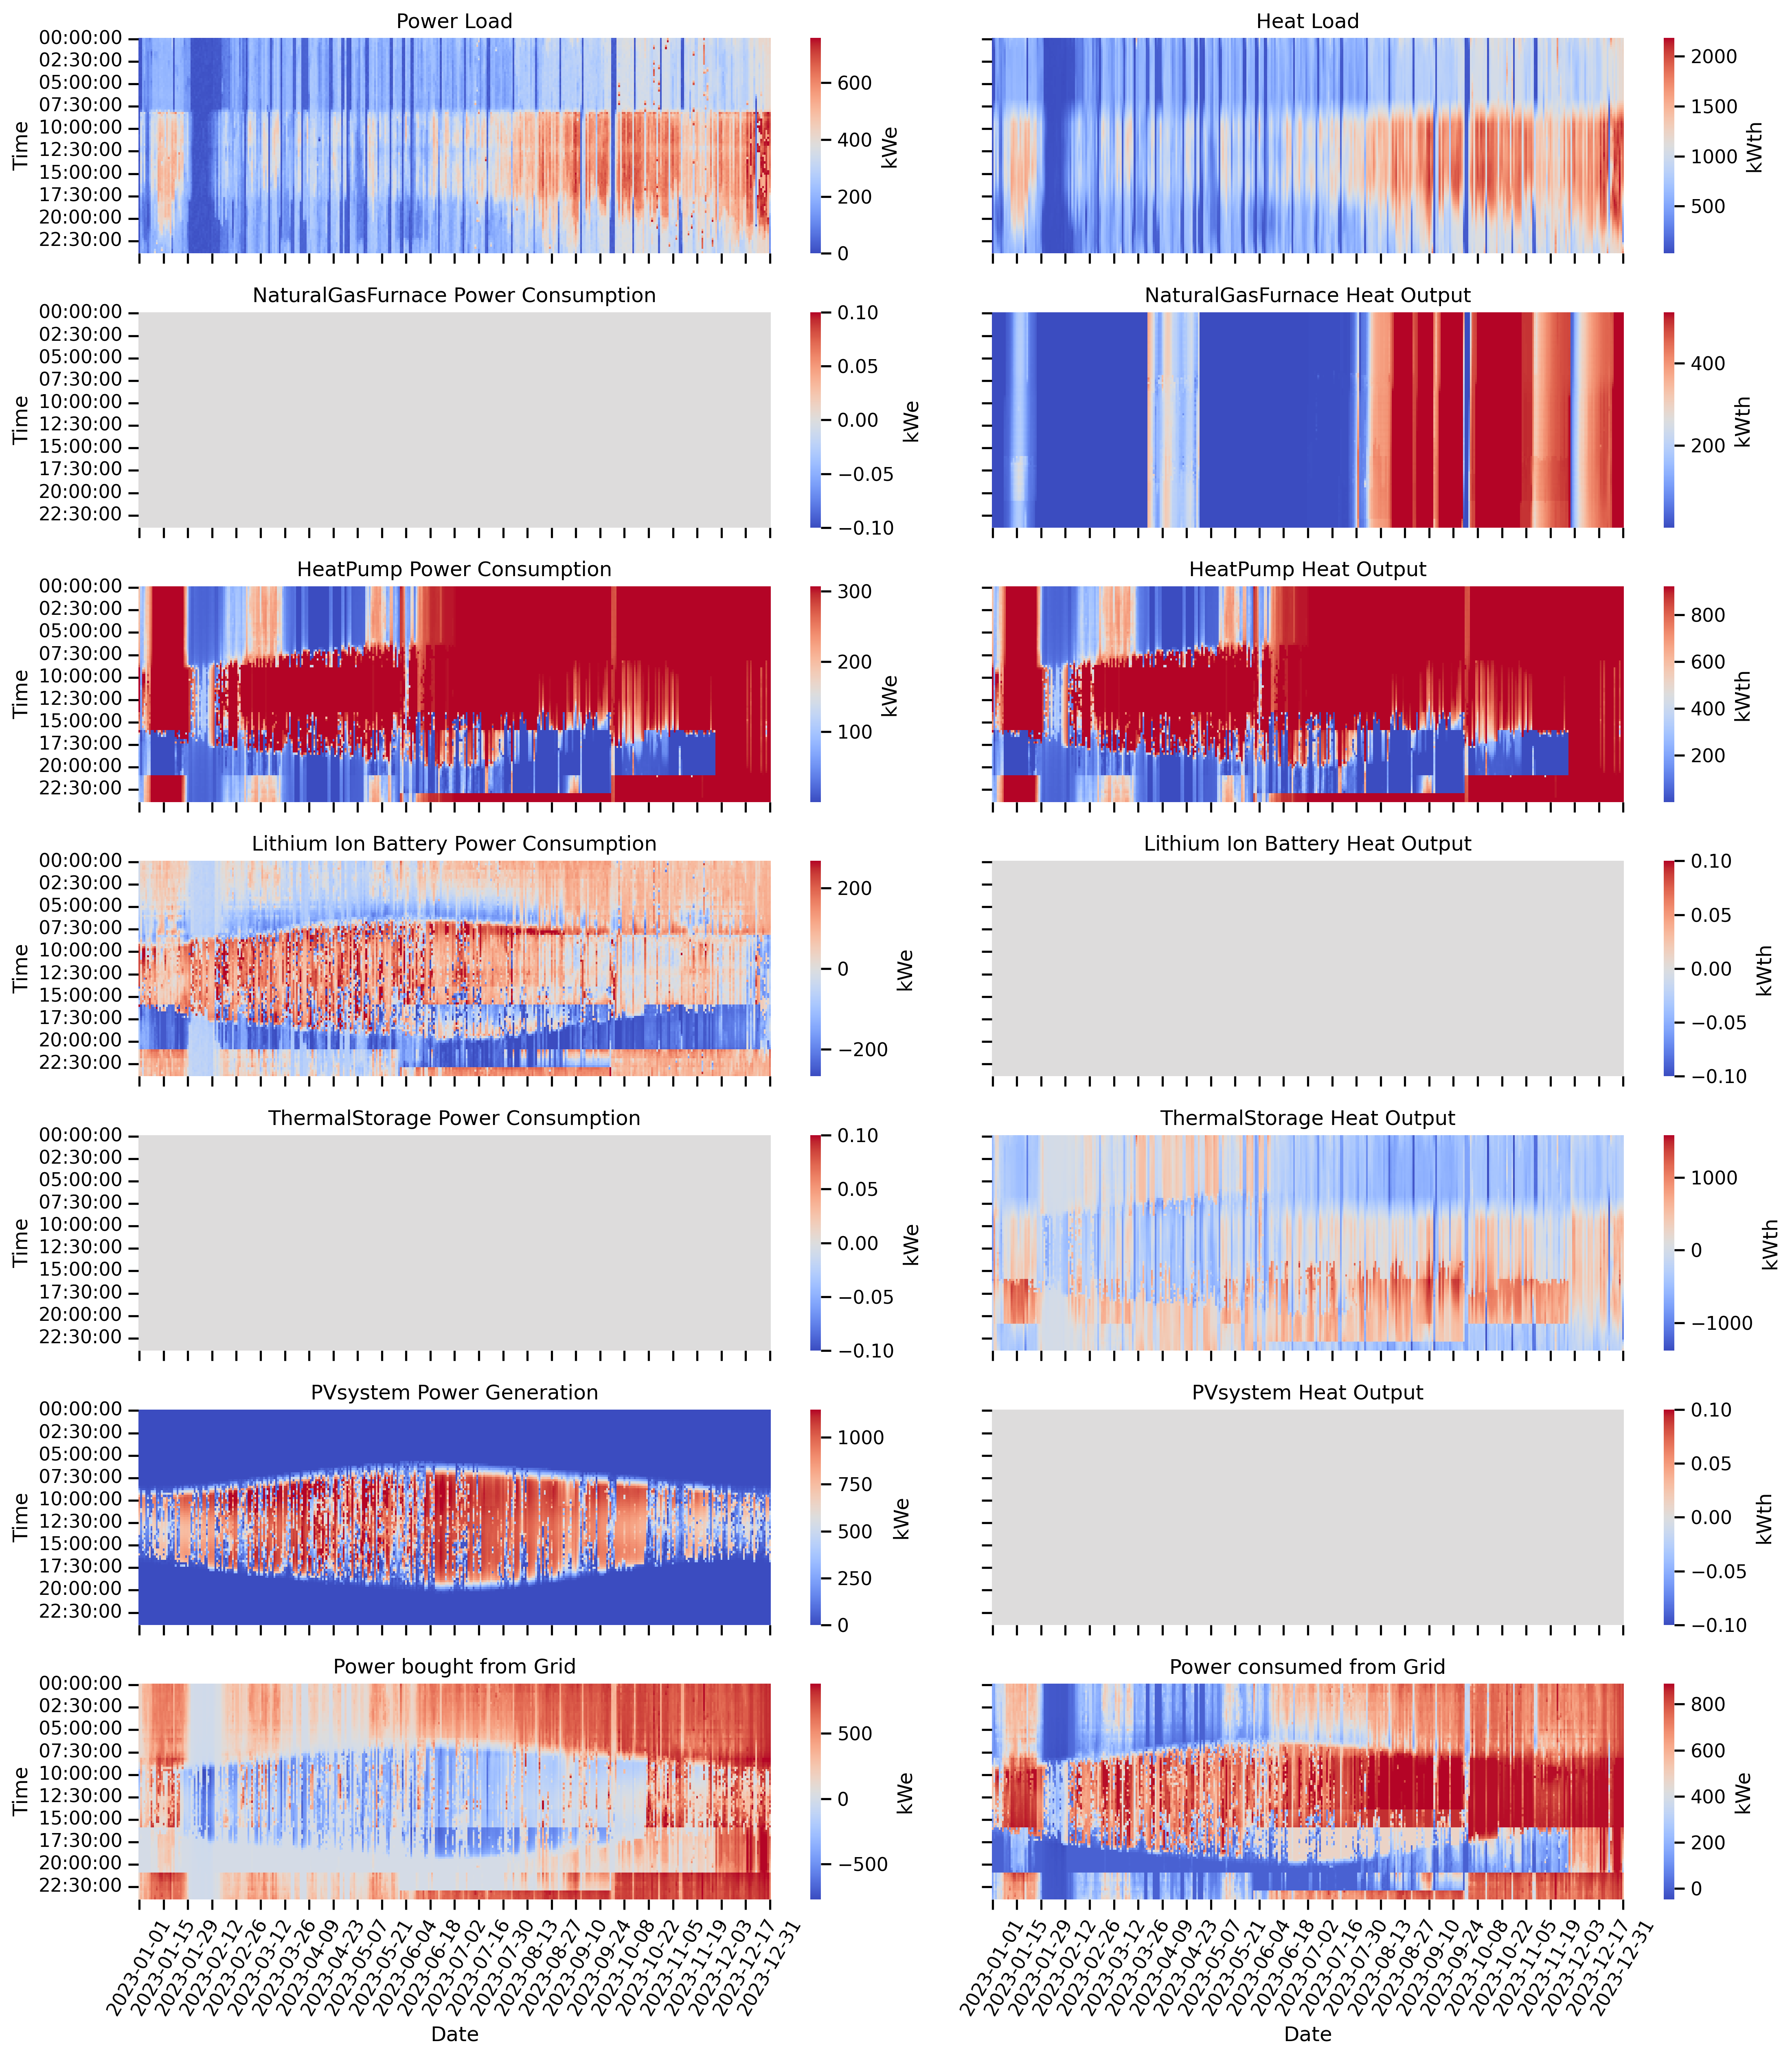

In [40]:
system1.plotHeatmaps();

In [41]:
colors = {'HeatPump': 'C0', 'Power Load': 'C1', 'Lithium Ion Battery': 'C4', 'Total Power Consumption': 'black', 'PVsystem': 'C2', '':'C4',
          'NaturalGasFurnace' : 'C5', 'Heat Load': 'C3', 'ThermalStorage': 'C4', 'Total Heat Consumption': 'black',
          'Marginal Power Price': 'C3', 'Marginal Power Emissions': 'C5'}
# empty string is for the battries when negative

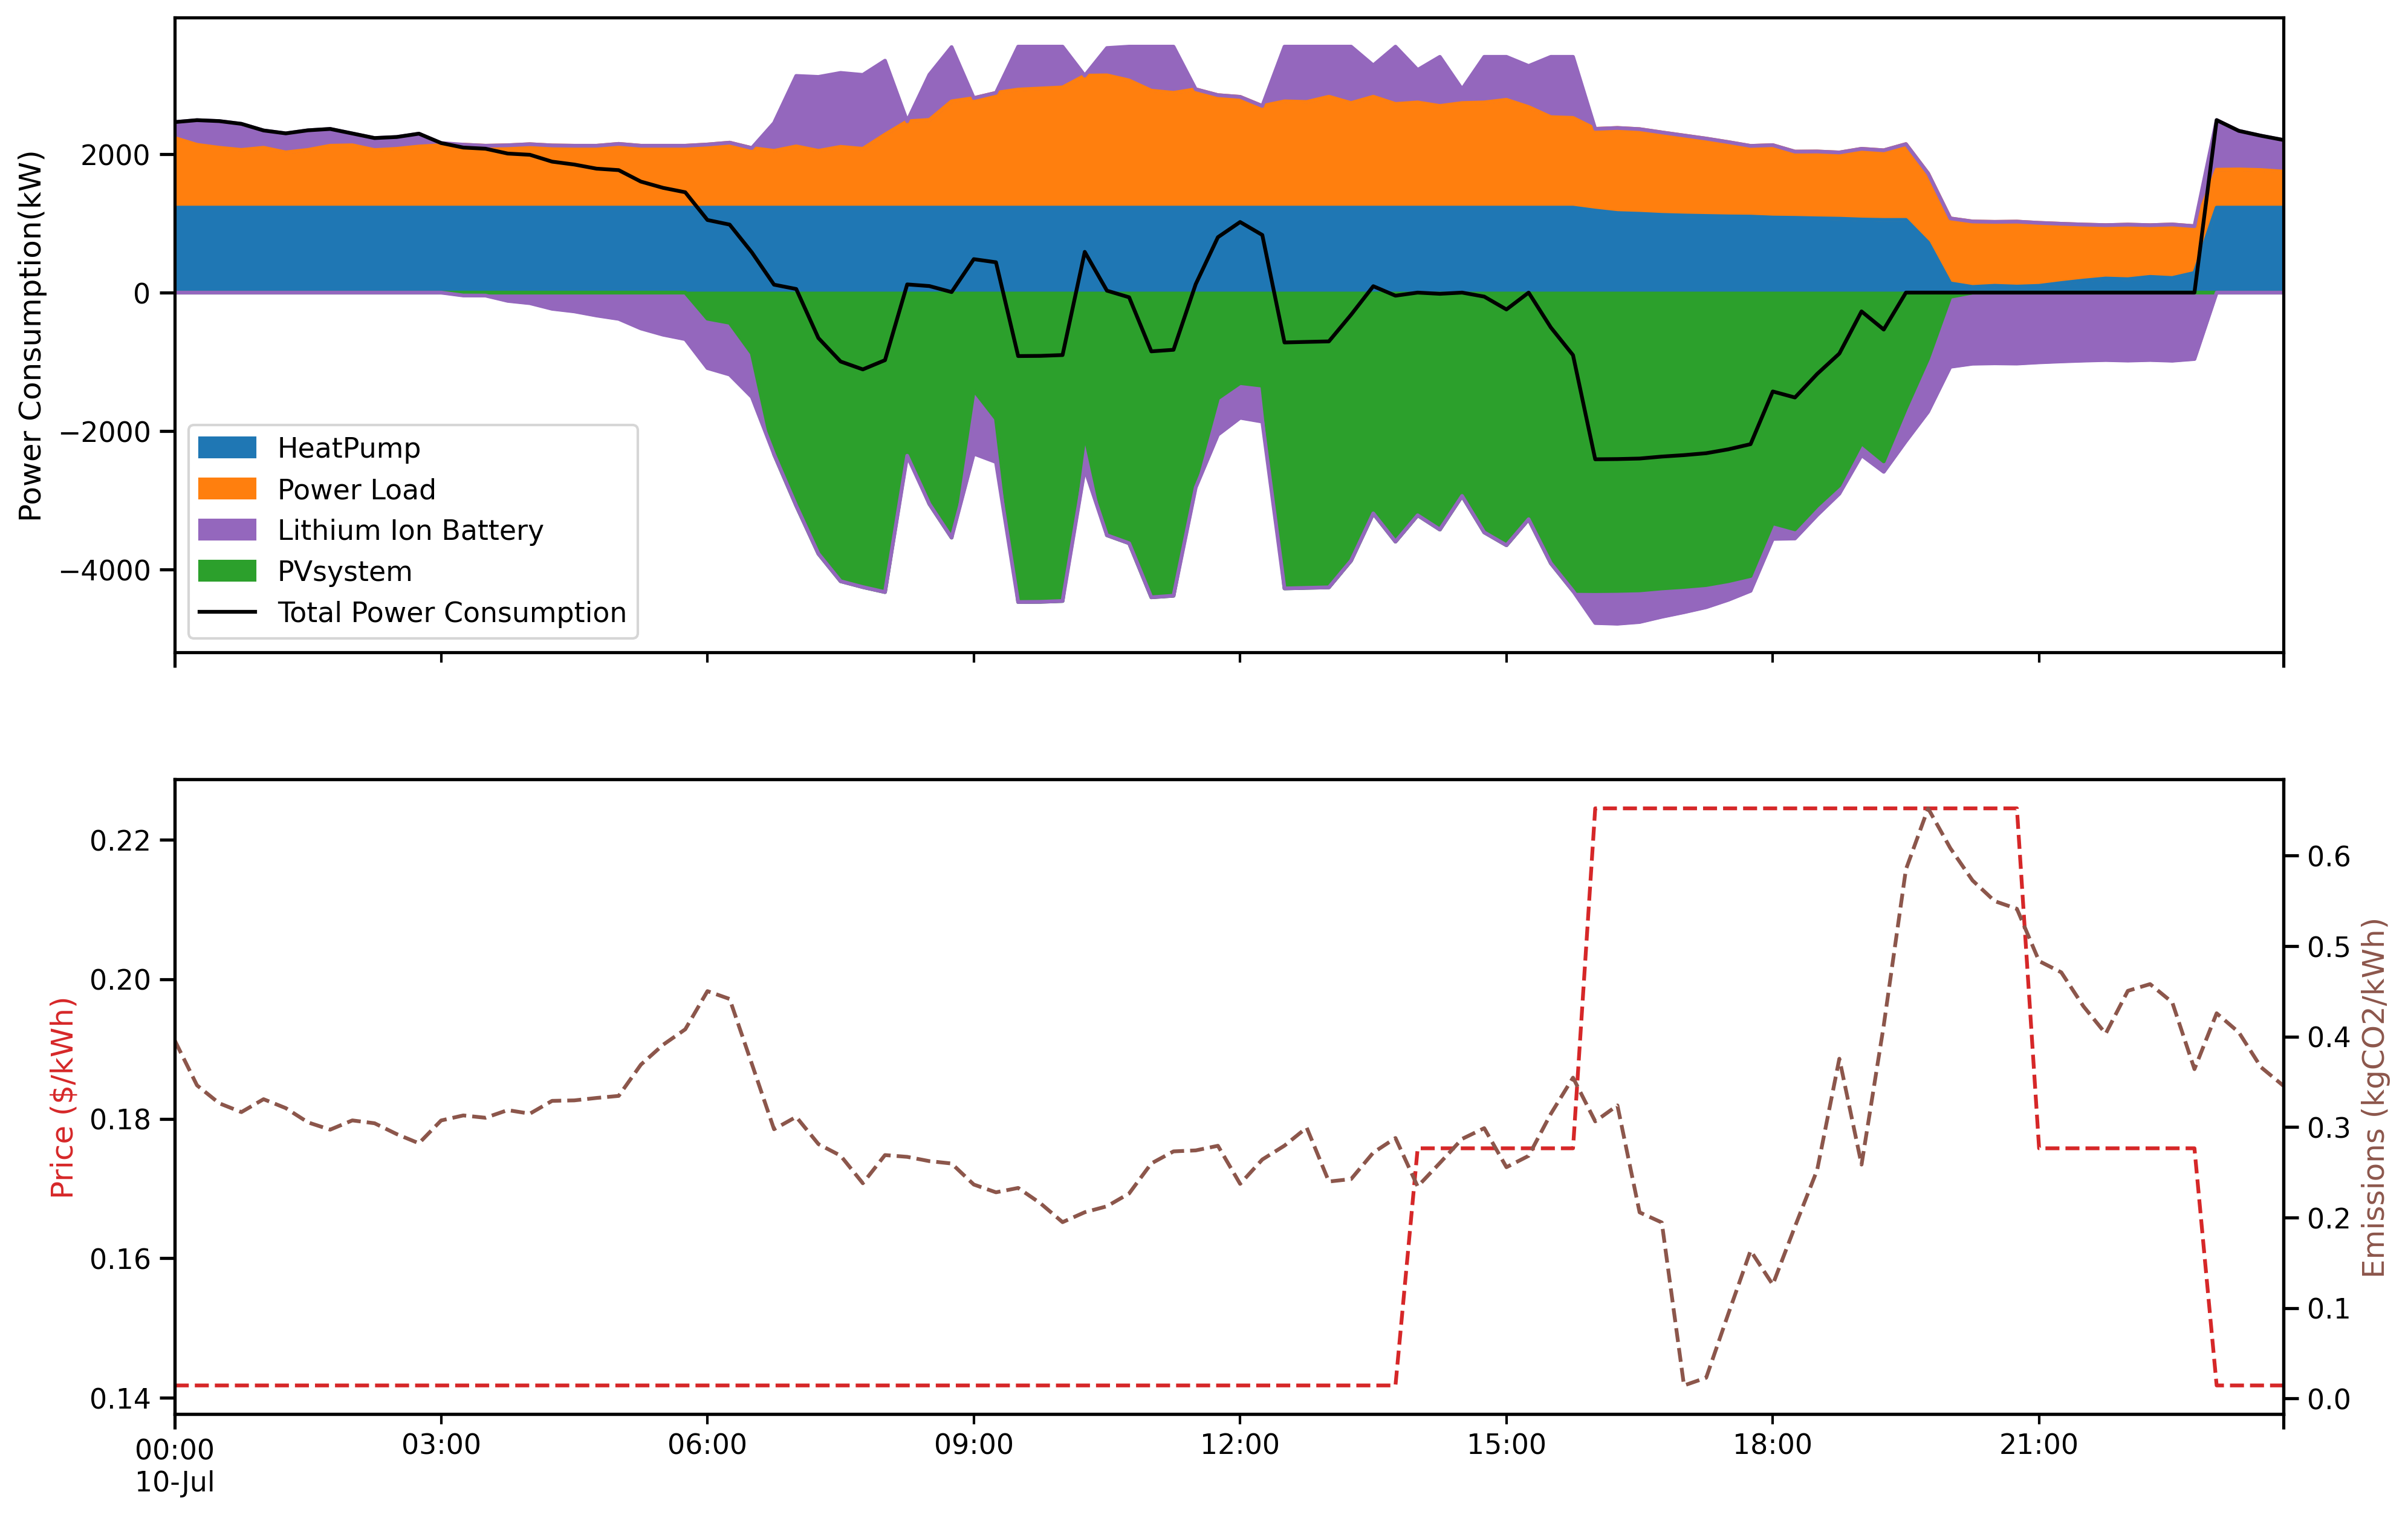

In [42]:
powerConsumers = ['HeatPump', 'Power Load']
powerStorage = ['Lithium Ion Battery']
powerGenerators = ['PVsystem']
system1.plot_power(colors, powerConsumers, powerStorage, powerGenerators, '2023-07-10');

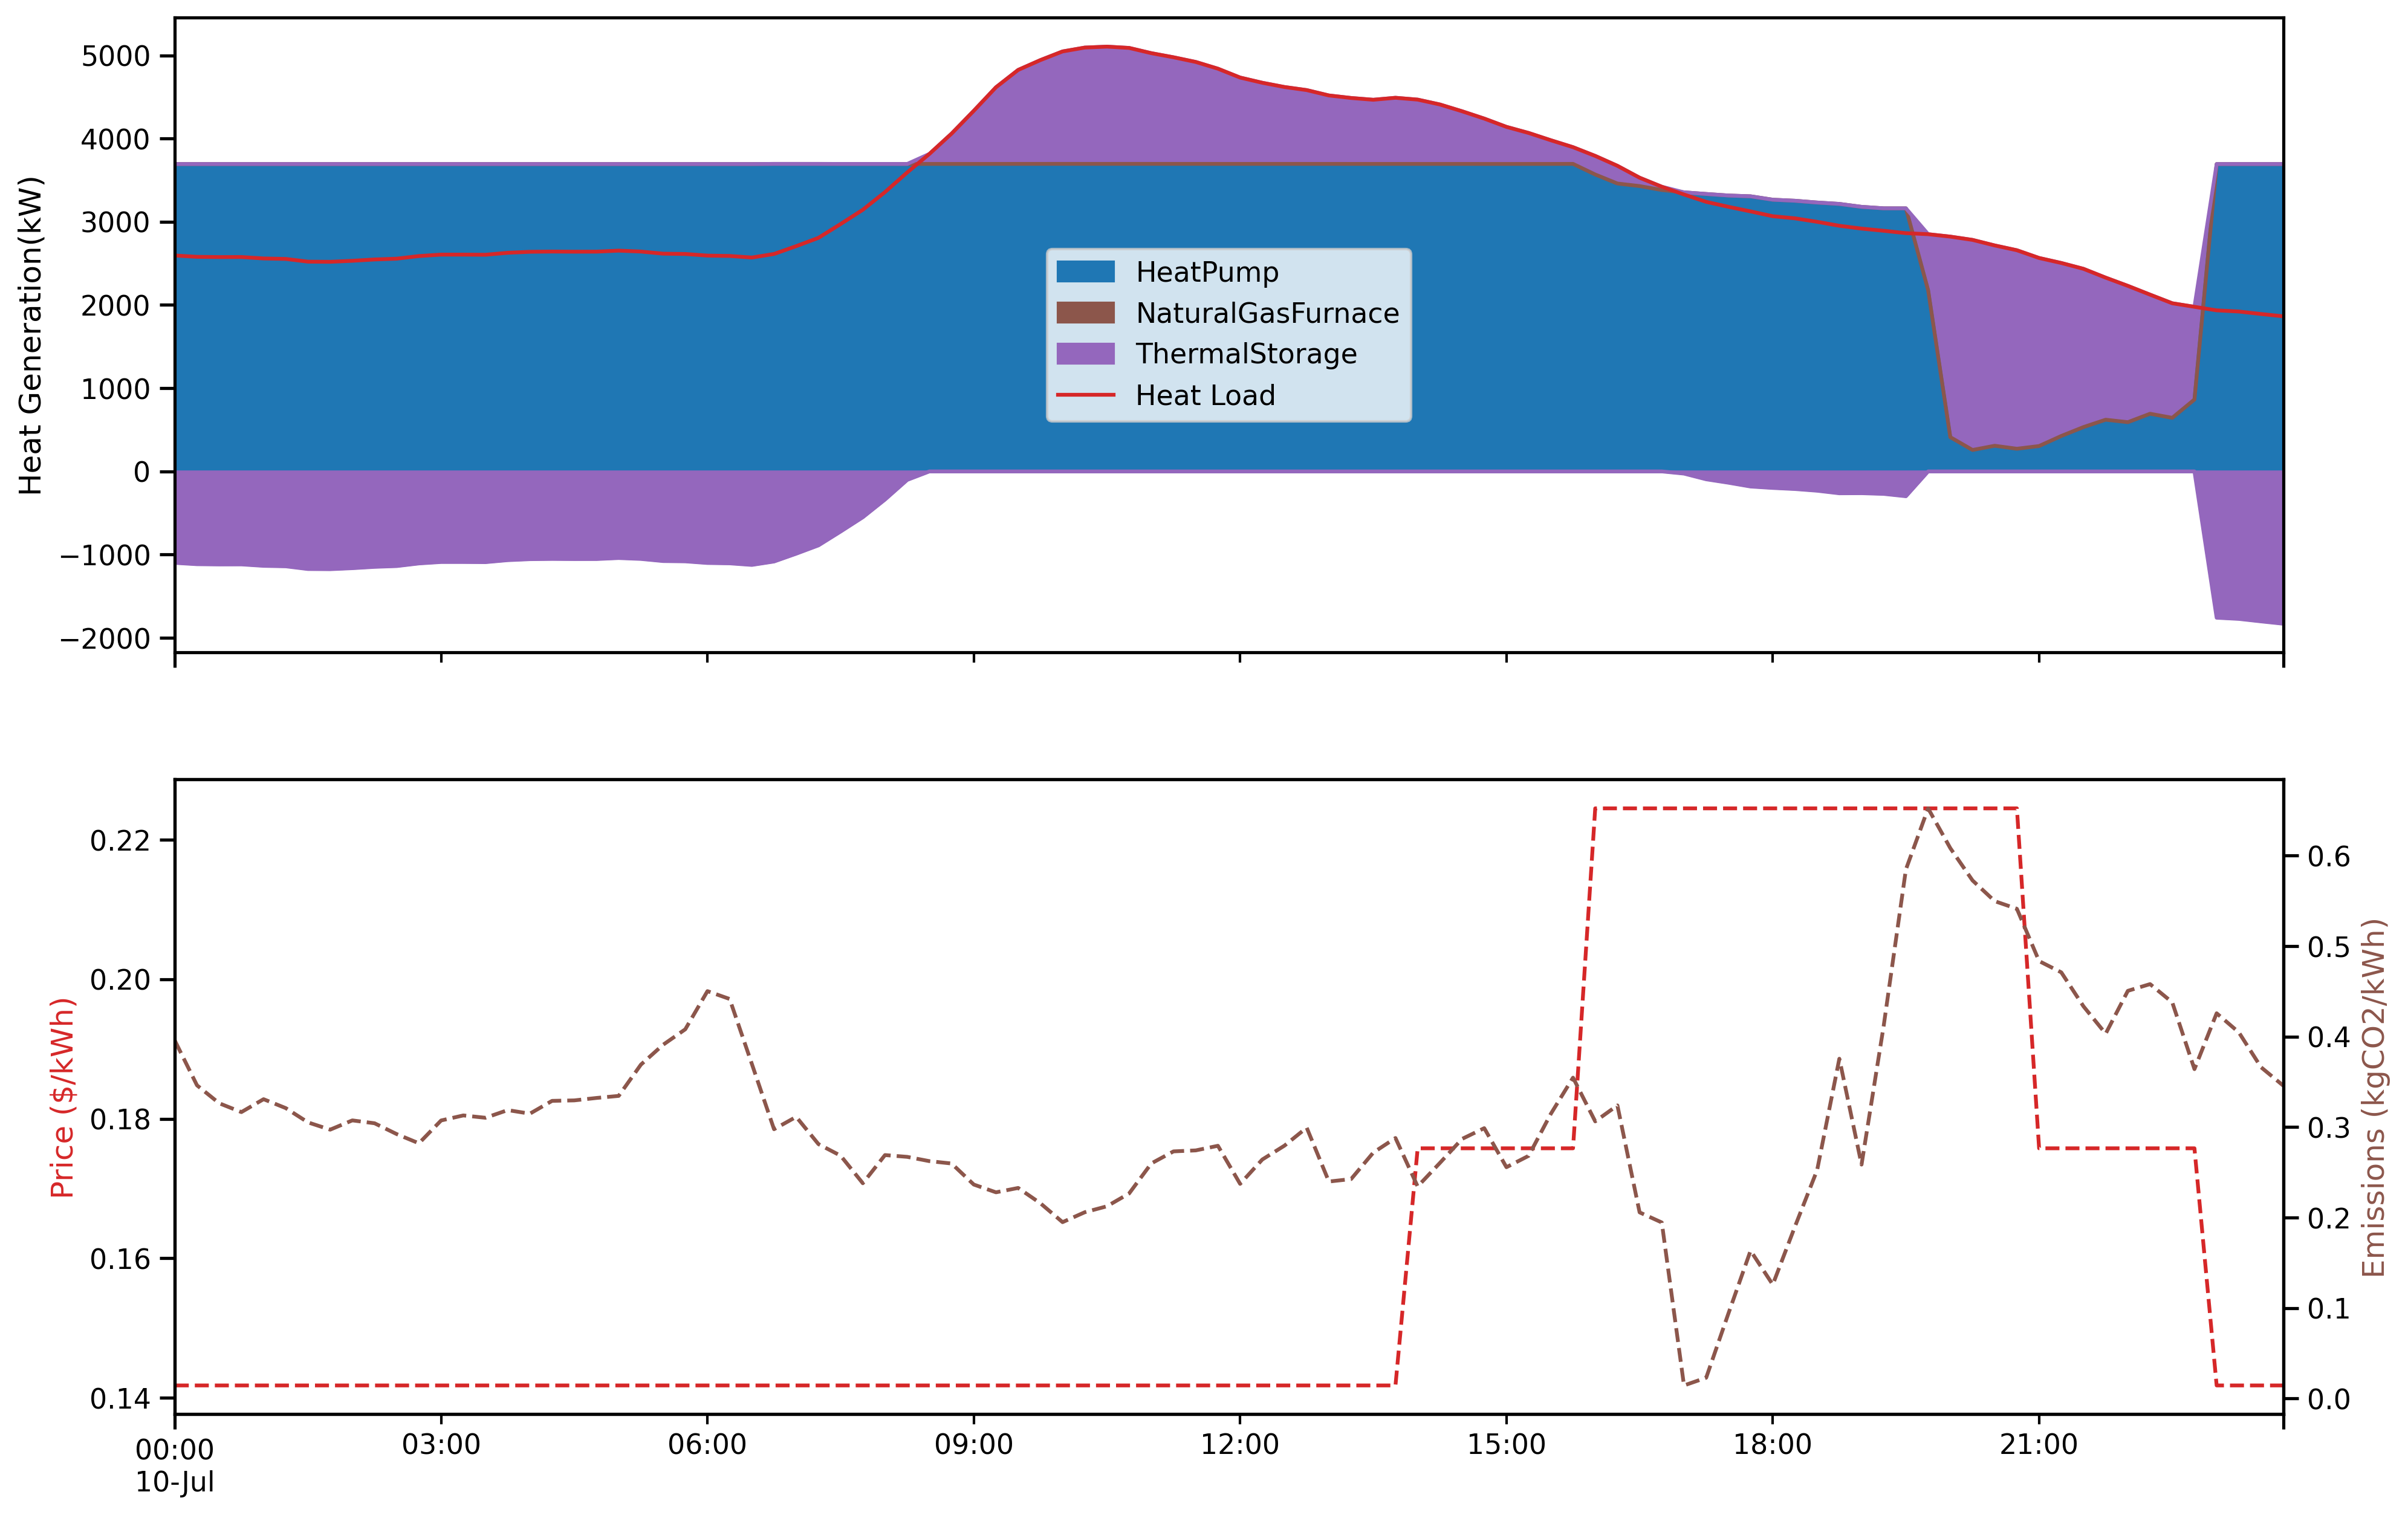

In [43]:
heatGenerators = ['HeatPump', 'NaturalGasFurnace']
heatStorage = ['ThermalStorage']
test = system1.plot_heat(colors, heatGenerators, heatStorage, '2023-07-10')

In [44]:
print(f"Heat Pump load factor: {np.round(100 * np.sum(hp1.heatOutput.value) / (hp1.capacity.value*8760), 2)} %")

Heat Pump load factor: 68.35 %
